# Reproduction: Planning in Dynamic Environments with Conditional Autoregressive Models

**Abhinav Madahar (<abhinav.madahar@rutgers.edu>) &middot; Sungjin Ahn**

In [114]:
import itertools
import math
import random
from collections import namedtuple
from enum import Enum
from math import ceil, log, log10, sqrt
from multiprocessing import Pool, cpu_count

import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as nn
from IPython.core.display import HTML
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import medfilt
from torch import autograd, optim
from torch.autograd import Variable

%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
random.seed(0)

## Making the Environment

We first make the environment.
These are some, but not all, of the parts I need to finish to make the environment.

At first, the agent will be a simple VAE.

I want the `Environment` class to be completely deterministic, assuming that the model is deterministic.
The randomness, like for placing the goal and agent, are separated into other functions.
We also create an enum to keep track of whether the current game is running, has been won, or has been lost.

In [2]:
def flatten(nested):
    values = []
    for element in nested:
        try:
            values = values.concat(flatten(element))
        except:
            values.append(element)
    return values
                    
def sgn(val):
    if val > 0:
        return 1
    elif val == 0:
        return 0
    else:
        return -1

class Vector2D:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __add__(self, v):
        return Vector2D(self.x + v.x, self.y + v.y)
    
    def __mul__(self, a):
        return Vector2D(a * self.x, a * self.y)
    
    def __repr__(self):
        return '{}({}, {})'.format(type(self).__name__, self.x, self.y)
    
    def __eq__(self, v):
        return self.x == v.x and self.y == v.y
    
    def __iter__(self):
        yield self.x
        yield self.y

class Position(Vector2D): 
    pass

class Velocity(Vector2D): 
    pass
        
def random_position(height, width):
    """Generates a psuedorandom position where 0 <= x < height and 0 <= y < width. The x and y are integers."""
    return Position(random.randrange(height), random.randrange(width))

def random_velocity(speed):
    theta = random.uniform(-1, 1) * math.pi
    return Velocity(speed * math.cos(theta), speed * math.sin(theta))

class GameState(Enum):
    WON = 0
    COLLIDED = 1
    TIMEOUT = 2
    
class Direction(Enum):
    LEFT = 0
    RIGHT = 1
    
ObstacleClass = namedtuple('ObstacleClass', ['length', 'speed'])
Obstacle = namedtuple('Obstacle', ['obstacle_class', 'position'])

def obstacle_from_class_id(id):
    """The `id` argument is the class ID in [0, 1, 2, 3, 4]."""
    obstacle_classes = [
        ObstacleClass(3, 1),
        ObstacleClass(3, 2),
        ObstacleClass(6, 1),
        ObstacleClass(6, 2),
        ObstacleClass(1.5, 0.5),
    ]
    return obstacle_classes[id]

def random_obstacle_lanes(n_lanes):
    return [obstacle_from_class_id(random.randrange(5)) for _ in range(n_lanes)]

We can now make the `Environment` class.

In [3]:
def model_decision():
    """Get the model's decision on where to move given the current environment using integers 0 through 7.
    This is redefined after the model is created."""
    # until I replicate the model, it will always select action 0
    return 0

class Environment:
    def __init__(self, height, width, goal_pos, goal_vel, max_time, level):
        """
            Initialize the environment.
            
            Args:
                height: int, the height of the environment.
                width: int, the width of the environment.
                goal_pos: Position, the initial position of the goal; the goal is 2x2, so the goal_pos is its bottom-left corner.
                goal_vel: Velocity, the velocity of the goal at the start of the experiment. This can change if it hits a wall.
                max_time: int, the maximum number of timesteps which can elapse before an automatic loss.
        """
        
        self.height = height
        self.width = width
        
        assert 0 <= goal_pos.x <= width - 1
        assert 0 <= goal_pos.y <= height - 1  # ditto
        self.goal_pos = goal_pos

        self.goal_vel = goal_vel
        
        self.max_time = max_time
        self.time = 0
        
        # randomly assign obstacle lanes for each lane.
        # note that a single lane can have multiple obstacles, so we have a list of obstacles in each lane
        n_obstacle_lanes = self.height
        self.n_obstacle_lanes = n_obstacle_lanes
        self.obstacle_classes = random_obstacle_lanes(n_obstacle_lanes)
        self.obstacle_directions = [Direction(random.randrange(2)) for _ in range(n_obstacle_lanes)]
        self.obstacle_lanes = [[] for _ in range(n_obstacle_lanes)]
        
        self.level = level
        self.add_obstacles()
    
    def __repr__(self):
        return 'Environment(height={}, width={}, agent_pos={}, goal_pos={}, agent_speed={}, goal_vel={})'.format(
            self.height, self.width, self.agent_pos, self.goal_pos, self.agent_speed, self.goal_vel)
    
    def __str__(self):
        """An ASCII diagram of the environment."""

        board = '|' + '-' * self.width + '|\n'
        for row in range(self.height):
            board += '|'
            for col in range(self.width):
                if Position(row, col) == self.rounded(self.agent_pos):
                    board += 'a'
                elif Position(row, col) in self.hitbox(self.goal_pos, (2, 2)):
                    board += 'g'
                else:
                    board += ' '
            board += '|\n'
        board += '|' + '-' * self.width + '|'
        
        return board
    
    def move(self):
        """Makes all the objects move in a single timestep and returns the game state."""
        
        def move_object(obj, vel):
            # instead of making a good solution, I made an easy one.
            # we move the object by velocity * dt where dt is a small scalar.
            # if we go out of bounds, then we flip the coordinate(s) which are out of bounds
            dt = 0.01
            for _ in range(int(1 / dt)):
                obj += vel * dt
                
                if obj.x < 0:
                    vel.x = abs(vel.x) * 1  # make sure to go right
                elif obj.x > self.width:
                    vel.x = abs(vel.x) * -1  # make sure to go left
                    
                if obj.y < 0:
                    vel.y = abs(vel.y) * 1  # make sure to go up
                elif obj.y > self.height:
                    vel.y = abs(vel.y) * -1  # make sure to go down

            
            return obj
        
        self.goal_pos = move_object(self.goal_pos, self.goal_vel)

        # we move the obstacles
        for lane, direction in zip(self.obstacle_lanes, self.obstacle_directions):
            for j, obstacle in enumerate(lane):
                speed     = obstacle.obstacle_class.speed
                direction = 1 if direction == Direction.RIGHT else -1
                obstacle.position.y += direction * speed

        self.remove_out_of_bounds_obstacles()
        self.add_obstacles()
        
        self.time += 1

    def hitbox(self, position, shape: [int, int]):
        """
        Returns an array of all the positions which are in this element's hitbox.
        Note that shape = [length in x, height in y].
        """
        
        position = self.rounded(position)
        hitboxes = []
        for offset_y in range(ceil(shape[0])):
            for offset_x in range(ceil(shape[1])):
                hitboxes.append(Position(position.x + offset_x, position.y + offset_y))
        return hitboxes

    def rounded(self, position):
        return Position(round(position.x), round(position.y))
    
    def add_obstacles(self):
        """Add obstacles based on a Poisson distribution."""
        
        # decide into which lanes to add obstacles
        number_obstacles_to_introduce = np.random.poisson(lam=self.level)
        obstacle_lanes = list(range(self.n_obstacle_lanes))
        random.shuffle(obstacle_lanes)
        lanes_in_which_we_add_obstacles = obstacle_lanes[:number_obstacles_to_introduce]
        
        for lane in lanes_in_which_we_add_obstacles:
            end = 0 if self.obstacle_directions[lane] == Direction.RIGHT else self.width
            obstacle = Obstacle(self.obstacle_classes[lane], Position(lane, end))
            self.obstacle_lanes[lane].append(obstacle)
        
    def remove_out_of_bounds_obstacles(self):
        for lane, direction in zip(self.obstacle_lanes, self.obstacle_directions):
            for j, obstacle in enumerate(lane):
                left_moving_and_out_of_bounds = direction == Direction.LEFT and obstacle.position.x + obstacle.obstacle_class.length < 0
                right_moving_and_out_of_bounds = direction == Direction.RIGHT and obstacle.position.x + obstacle.obstacle_class.length > self.width
                
                if left_moving_and_out_of_bounds or right_moving_and_out_of_bounds:
                    lane.pop(j)

    def model_readable_representation(self):
        """Represents the environment using a torch tensor. A point is 0 if empty, 1 if an obstacle is there, and 2 for goal."""
        
        # we have to increment because (self.width, self.height) is a valid point on the board
        rep = np.zeros([self.width+1, self.height+1], dtype=np.float64)
        
        obstacles = []
        for lane in self.obstacle_lanes:
            for obstacle in lane:
                obstacles.append(obstacle)
        obstacle_points = []
        for obstacle in obstacles:
            for point in environment.hitbox(obstacle.position, [obstacle.obstacle_class.length, 1]):
                obstacle_points.append(point)
        
        for position in obstacle_points:
            # obstacles can sometimes go beyond the bounds along the x-axis, 
            # which is valid but makes it impossible to put them on the representation.
            if 0 <= position.x <= self.width and 0 <= position.y <= self.height:
                rep[position.x][position.y] = 1

        goal_hitpoints = self.hitbox(self.goal_pos, [2, 1])
        for position in goal_hitpoints:
            if 0 <= position.x < self.width and 0 <= position.y <= self.height:
                rep[position.x][position.y] = 2
        
        return rep

We can make an environment and see what it looks like when it's run.

In [4]:
height = 45
width = 45
max_time = 407
goal_speed = 1
goal_pos = random_position(height-1, width-1)
goal_vel = random_velocity(goal_speed)
level = 1

In [5]:
%%capture

environment = Environment(height, width, goal_pos, goal_vel, max_time, level)

fig = plt.figure()
ax = plt.axes(xlim=(0, height), ylim=(0, width))
a = np.random.random((height, width))
cmap = LinearSegmentedColormap.from_list('mycmap', ['purple'])
im = plt.imshow(a, interpolation='none', cmap='plasma')

def animate(i):
    frame = environment.model_readable_representation()
    a = im.get_array()
    a = frame
    im.set_array(a)
    environment.move()

    return [im]
    
animation = matplotlib.animation.FuncAnimation(fig, animate, frames=50)

We now generate a dataset of frames, which we call $X$. It can take a long time to make the dataset, so we prefer to save and reload it.
Note that the computer might not be able to hold all 800,000 frames in memory at once; my laptop can only hold 500,000.

In [6]:
%%time

n_data_points = 1000  # they used about 800,000 in the original paper

try:
    X = np.load('autoencoder-data.npy')
    if len(X) > n_data_points:
        X = X[:n_data_points]
    elif len(X) < n_data_points:
        # we have to make more
        raise ValueError('insufficiently-many frames in dataset.')
except (FileNotFoundError, ValueError) as e:
    if isinstance(e, FileNotFoundError):
        # if we couldn't load the file, then we need to make an entire dataset from scratch
        X = np.zeros((n_data_points, (height + 1) * (width + 1)), dtype=np.float32)
        n_data_points_collected = 0
    else:
        # we extend the old X to have enough space for the new dataset
        old_X = X
        X = np.zeros((n_data_points, (height + 1) * (width + 1)), dtype=np.float32)
        for i, frame in enumerate(old_X):
            X[i] = frame
        n_data_points_collected = len(old_X)

    while n_data_points_collected < n_data_points:
        environment = Environment(height, width, agent_pos, goal_pos, agent_speed, goal_vel, max_time, level)
        rep = environment.model_readable_representation().flatten()
        X[n_data_points_collected] = rep
        n_data_points_collected += 1
        while n_data_points_collected < n_data_points:
            X[n_data_points_collected] = environment.model_readable_representation().flatten()
            environment.move()
            n_data_points_collected += 1
    np.save('autoencoder-data.npy', X)

CPU times: user 0 ns, sys: 44.8 ms, total: 44.8 ms
Wall time: 43.3 ms


# Making the Planning Model

The environmental model takes in 5 states of the environment and predicts the next state.

![Model Overview](figs/model-overview.png)

There are 2 components of this model:

- an autoencoder which converts a frame to a representation
- a predictive model which predicts the next frame's representation.

We first make and train the first component, and then the second.
In the final model, the predictive model actually takes 5 consecutive frames' representations, but that's a minor detail we'll add later.
We note that both the autoencoder and the predictive model are trained in a supervised manner.

We first define the hyperparameters.
We use a `Z_dim` of 36 because the final model will use a 6x6x1 Z-representation instead of a continuous real vector.
We set `h_dim` to 200 because it seems like a good number.

In [7]:
x_dim = (width + 1) * (height + 1)
h_dim = 200
Z_dim = 36
lr = 0.001
n_train_epochs = 10
batch_size = 100

We can now make the model itself, which is a simple encoder-decoder model.

We use Xavier initialization for the weights.
The encoder is a 1-hidden-layer feed forward neural network, and the decoder is the same.

In [8]:
def xavier_init(size):
    input_dim = size[0]
    xavier_stdev = 1 / np.sqrt(input_dim / 2)
    return Variable(torch.randn(*size) * xavier_stdev, requires_grad=True)


Wxh = xavier_init(size=[x_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)
Whh = xavier_init(size=[h_dim, h_dim])
bhh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)


def Q(x):
    x = x.float()  # correct type and shape
    
    # the model expects the input to have shape [batch size, width+1, height+1], which is then flattened.

    if x.shape == (width+1, height+1):
        x = x.reshape([1, (width+1)*(height+1)])
    
    h = nn.relu(x @ Wxh + bxh)
    h = nn.relu(h @ Whh + bhh)
    z_mu = h @ Whz_mu + bhz_mu
    z_var = h @ Whz_var + bhz_var
    max_z_var = 87.
    # we have to keep the variance within a reasonable bound
    # because we take the exponent of it when we find the loss,
    # and it overflows past max_z_var
    z_var = torch.clamp(z_var, min=-max_z_var, max=max_z_var)
    return z_mu, z_var


def sample_z(mu, log_var):
    eps = Variable(torch.randn(batch_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps


Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, x_dim])
bhx = Variable(torch.zeros(x_dim), requires_grad=True)


def P(z):
    h = nn.relu(z @ Wzh + bzh)
    x = torch.sigmoid(h @ Whx + bhx)
    return x

In [9]:
%%time

n_data_points = 5000  # they used about 800,000 in the original paper

try:
    X = np.load('autoencoder-data.npy')
    if len(X) > n_data_points:
        X = X[:n_data_points]
    elif len(X) < n_data_points:
        # we have to make more
        raise ValueError('insufficiently-many frames in dataset.')
except (FileNotFoundError, ValueError) as e:
    if isinstance(e, FileNotFoundError):
        # if we couldn't load the file, then we need to make an entire dataset from scratch
        X = np.zeros((n_data_points, (height + 1) * (width + 1)), dtype=np.float32)
        n_data_points_collected = 0
    else:
        # we extend the old X to have enough space for the new dataset
        old_X = X
        X = np.zeros((n_data_points, (height + 1) * (width + 1)), dtype=np.float32)
        for i, frame in enumerate(old_X):
            X[i] = frame
        n_data_points_collected = len(old_X)

    while n_data_points_collected < n_data_points:
        environment = Environment(height, width, agent_pos, goal_pos, agent_speed, goal_vel, max_time, level)
        rep = environment.model_readable_representation().flatten()
        X[n_data_points_collected] = rep
        n_data_points_collected += 1
        while n_data_points_collected < n_data_points:
            rep = environment.model_readable_representation().flatten()
            X[n_data_points_collected] = rep
            environment.move()
            n_data_points_collected += 1
    np.save('autoencoder-data.npy', X)

CPU times: user 0 ns, sys: 43.8 ms, total: 43.8 ms
Wall time: 42.3 ms


Let's train the autoencoder now.

In [10]:
params = [Wxh, Whh, bhh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]

solver = optim.Adam(params, lr=lr)
losses = []
losses_in_epoch = []
losses_avg_per_epoch = []

X_torch = torch.from_numpy(X)

for epoch in range(n_train_epochs):
    print('Beginning epoch {}'.format(epoch))
    shuffled_indices = torch.randperm(len(X))
    batches_indices = []
    batch_indices = []
    for index in shuffled_indices:
        batch_indices.append(index)
        if len(batch_indices) == batch_size:
            batches_indices.append(batch_indices)
            batch_indices = []
            
    losses_in_epoch = []
    for batch_indices in batches_indices:
        batch = Variable(X_torch[batch_indices])
        y_true = Variable(X_torch[batch_indices])
        
        # Forward
        z_mu, z_var = Q(batch)
        z = sample_z(z_mu, z_var)
        y_pred = P(z)

        # Loss
        recon_loss = nn.binary_cross_entropy(y_pred, y_true, reduction='sum') / batch_size
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        loss = recon_loss + kl_loss
        
        losses.append(loss)
        losses_in_epoch.append(loss)
        
        # Backward
        loss.backward()

        # Update
        solver.step()
        
    losses_avg_per_epoch.append(sum(losses_in_epoch) / len(batch_indices))

Beginning epoch 0
Beginning epoch 1
Beginning epoch 2
Beginning epoch 3
Beginning epoch 4
Beginning epoch 5
Beginning epoch 6
Beginning epoch 7
Beginning epoch 8
Beginning epoch 9


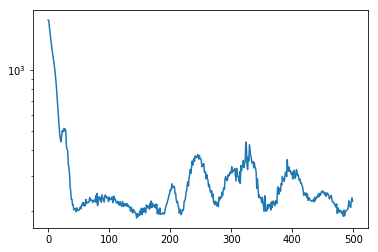

In [11]:
plt.plot(medfilt(losses))
plt.yscale('log')

In [12]:
def encode(frame):
    """Accepts a numpy ndarray."""
    frame = torch.from_numpy(frame)
    return Q(frame)


def decode(representation):
    frames_generated = P(sample_z(*representation)).reshape(batch_size, height+1, width+1)
    frame = frames_generated[0]
    frame = np.float64(frame.detach().numpy())
    return frame

We can compare the model's predicted next frame with the actual next frame.

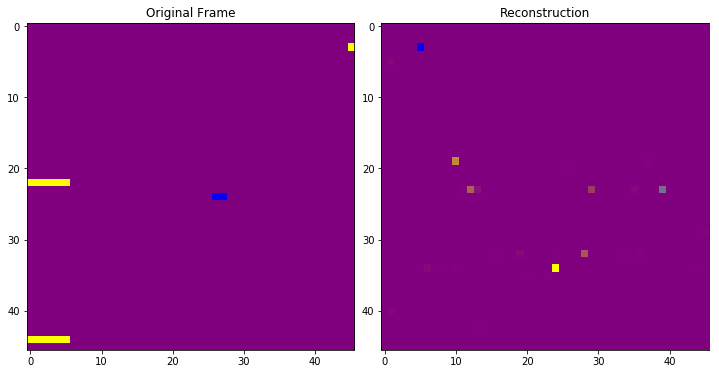

In [13]:
environment = Environment(height, width, goal_pos, goal_vel, max_time, level)

frame = environment.model_readable_representation()
reconstruction = decode(encode(frame))

cmap = LinearSegmentedColormap.from_list('mycmap', ['purple', 'yellow', 'blue'])

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title('Original Frame')
plt.imshow(frame, cmap=cmap)
plt.subplot(222)
plt.title('Reconstruction')
plt.imshow(reconstruction, cmap=cmap)
plt.tight_layout()

Now, we can make the next-frame-predictor.
It takes the current frame's representation and predicts the next frame's representation.
We generate its training set by running the autoencoder on every frame, which is very fast.

In [14]:
representations_of_all_frames_z_mu, representations_of_all_frames_z_var = encode(X)

Now, we can train on the X representions.
For now, the model will be a simple neural network, not a gated CNN.

Beginning epoch 0
Beginning epoch 1
Beginning epoch 2
Beginning epoch 3
Beginning epoch 4
Beginning epoch 5
Beginning epoch 6
Beginning epoch 7
Beginning epoch 8
Beginning epoch 9


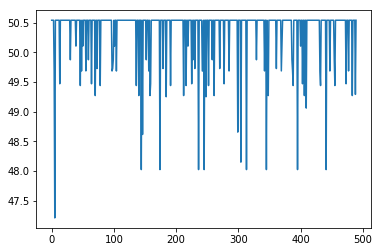

In [15]:
predict_future_n_train_epochs = 10
predict_future_lr = 0.01
predict_future_batch_size = 100
predict_future_h_dim = 50
predict_future_Wxh_z_mu = Variable(torch.zeros(Z_dim, predict_future_h_dim), requires_grad=True)
predict_future_bxh_z_mu = Variable(torch.zeros(predict_future_h_dim), requires_grad=True)
predict_future_Whx_z_mu = Variable(torch.zeros(predict_future_h_dim, Z_dim), requires_grad=True)
predict_future_bhx_z_mu = Variable(torch.zeros(Z_dim), requires_grad=True)
predict_future_trainable_params_z_mu = [predict_future_Wxh_z_mu, predict_future_bxh_z_mu]
solver = optim.Adam(predict_future_trainable_params_z_mu, lr=predict_future_lr)

def predict_future_z_mu(current_representation):
    """
    Predicts the next frame's VAE representation.
    For now, it just uses a single frame, but it will eventually use many previous frames.
    Args:
        current_representation: torch.Variable, should have shape [batch_size, Z_dim].
    Returns:
        The Z representation of the next frame.
    """
    
    h = nn.relu(current_representation @ predict_future_Wxh_z_mu + predict_future_bxh_z_mu)
    future_representation = nn.relu(h @ predict_future_Whx_z_mu + predict_future_bhx_z_mu)
    return future_representation

losses = []

for epoch in range(predict_future_n_train_epochs):
    print('Beginning epoch', epoch)
    shuffled_indices = torch.randperm(len(representations_of_all_frames_z_mu)-1)
    batches_indices = []
    batch_indices = []
    for index in shuffled_indices:
        batch_indices.append(index)
        if len(batch_indices) == predict_future_batch_size:
            batches_indices.append(batch_indices)
            batch_indices = []
           
    for batch_indices in batches_indices:
        x = Variable(representations_of_all_frames_z_mu[batch_indices])
        y_true = Variable(representations_of_all_frames_z_mu[[i + 1 for i in batch_indices]])
        
        # Forward
        y_pred = predict_future_z_mu(x)
        
        # Loss
        loss = nn.binary_cross_entropy(y_pred, y_true, reduction='sum') / predict_future_batch_size
        losses.append(loss)

        # Backward
        loss.backward()

        # Update
        solver.step()
        
plt.plot(losses);

Beginning epoch 0
Beginning epoch 1
Beginning epoch 2
Beginning epoch 3
Beginning epoch 4
Beginning epoch 5
Beginning epoch 6
Beginning epoch 7
Beginning epoch 8
Beginning epoch 9


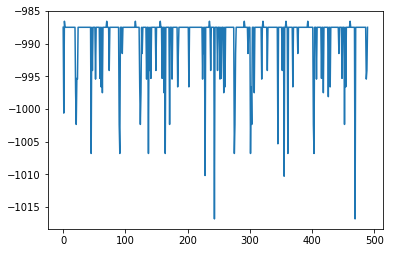

In [16]:
predict_future_n_train_epochs = 10
predict_future_lr = 0.01
predict_future_batch_size = 100
predict_future_h_dim = 50
predict_future_Wxh_z_var = Variable(torch.zeros(Z_dim, predict_future_h_dim), requires_grad=True)
predict_future_bxh_z_var = Variable(torch.zeros(predict_future_h_dim), requires_grad=True)
predict_future_Whx_z_var = Variable(torch.zeros(predict_future_h_dim, Z_dim), requires_grad=True)
predict_future_bhx_z_var = Variable(torch.zeros(Z_dim), requires_grad=True)
predict_future_trainable_params_z_var = [predict_future_Wxh_z_var, predict_future_bxh_z_var]
solver = optim.Adam(predict_future_trainable_params_z_var, lr=predict_future_lr)

def predict_future_z_var(current_representation):
    """
    Predicts the next frame's VAE representation.
    For now, it just uses a single frame, but it will eventually use many previous frames.
    Args:
        current_representation: torch.Variable, should have shape [batch_size, Z_dim].
    Returns:
        The Z representation of the next frame.
    """
    
    h = nn.relu(current_representation @ predict_future_Wxh_z_var + predict_future_bxh_z_var)
    future_representation = nn.relu(h @ predict_future_Whx_z_var + predict_future_bhx_z_var)
    return future_representation

losses = []

for epoch in range(predict_future_n_train_epochs):
    print('Beginning epoch', epoch)
    shuffled_indices = torch.randperm(len(representations_of_all_frames_z_var)-1)
    batches_indices = []
    batch_indices = []
    for index in shuffled_indices:
        batch_indices.append(index)
        if len(batch_indices) == predict_future_batch_size:
            batches_indices.append(batch_indices)
            batch_indices = []
           
    for batch_indices in batches_indices:
        x = Variable(representations_of_all_frames_z_var[batch_indices])
        y_true = Variable(representations_of_all_frames_z_var[[i + 1 for i in batch_indices]])
        
        # Forward
        y_pred = predict_future_z_var(x)
        
        # Loss
        loss = nn.binary_cross_entropy(y_pred, y_true, reduction='sum') / predict_future_batch_size
        losses.append(loss)

        # Backward
        loss.backward()

        # Update
        solver.step()
        
plt.plot(losses);

In [17]:
def predict_future(z_mu, z_var):
    return predict_future_z_mu(z_mu), predict_future_z_var(z_var)

From these components, we now have a model which predicts the future.
For now, we'll just use the actual environment playout because the model is not very accurate yet.

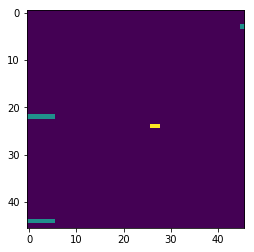

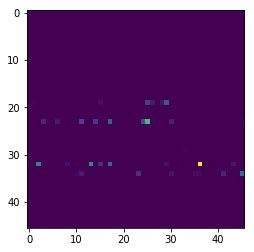

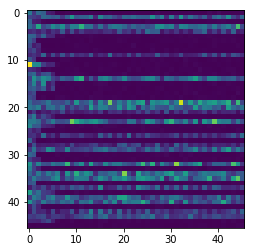

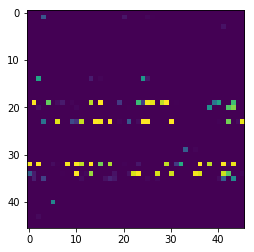

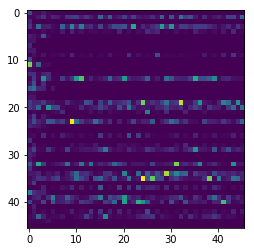

In [18]:
for _ in range(5):
    plt.imshow(frame)
    plt.show()
    frame = decode(predict_future(*encode(frame)))

In [19]:
environment = Environment(height, width, goal_pos, goal_vel, max_time, level)

environment_prediction = []
for _ in range(max_time):
    environment_prediction.append(environment.model_readable_representation())
    environment.move()

# Decision Making Component

Now, we use reinforcement learning with a Monte Carlo tree search to decide the direction of movement. 
The agent can move like a king in chess: up, down, left, right, or a diagonal.
From this, each node in the tree search has 8 children.
There are 8 moves available at every step, so there are more potential plays than there are atoms in the universe, by several orders of orders of magnitudes.
To decide where to move, we use a Monte Carlo Tree Search.

First, we create a few functions which let the agent move in the environment.

In [20]:
def agent_mask(agent_pos):
    mask = np.zeros((height+1, width+1))
    mask[int(agent_pos.x), int(agent_pos.y)] = 3.
    return mask


def bounce(agent_pos, height, width):
    epsilon = 10e-10
    
    if agent_pos.x < 0:
        x = abs(agent_pos.x)
    elif agent_pos.x >= width:
        x = 2 * width - agent_pos.x - epsilon
    else:
        x = agent_pos.x

    if agent_pos.y < 0:
        y = abs(agent_pos.y)
    elif agent_pos.y >= height:
        y = 2 * height - agent_pos.y - epsilon
    else:
        y = agent_pos.y
    
    return Position(x, y)


directions = [
    Velocity(-1/sqrt(2), 1/sqrt(2)),  Velocity(0, 1),  Velocity(1/sqrt(2), 1/sqrt(2)),
    Velocity(-1, 0),                                   Velocity(1, 0),
    Velocity(-1/sqrt(2), -1/sqrt(2)), Velocity(0, -1), Velocity(1/sqrt(2), -1/sqrt(2)),
]

environment = Environment(height, width, goal_pos, goal_vel, max_time, level)

Now, we can create the Monte Carlo Tree Search algorithm.
Consider the diagram below.

![MCTS](https://jeffbradberry.com/images/mcts_selection.png)

We evaluate a node's quality using upper confidence bound 1 for trees ("UCT"), defined by

![UCT](https://wikimedia.org/api/rest_v1/media/math/render/svg/b607bd848f08876b247148bad27c3c26a1066a0d)

where:
- $w_i$ stands for the number of wins for the node considered after the i-th move
- $n_i$ stands for the number of simulations for the node considered after the i-th move
- $c$ is the exploration parameter—theoretically equal to √2; in practice usually chosen empirically
- $N_i$ stands for the total number of simulations after the i-th move
    
To add a node using Monte Carlo Tree Search, we follow 4 steps:

1. **select** the most promosing move using UCT, recurring until we reach a leaf,
2. **expand** the leaf by choosing a random following move,
3. **simulation** a random play, recording whether we won or lost,
4. and **backpropogating** the won or loss up the tree and incrementing the number of times each node has been run.

And then we redo this until we feel satisfied. 

First, we make a `MCTSNode` data structure and a root for the tree.

In [21]:
class MCTSNode:
    def __init__(self, direction, wins, timeouts, collisions, runs, parent, children):
        self.direction = direction
        self.wins = wins
        self.collisions = 0
        self.timeouts = 0
        self.runs = runs
        self.parent = parent
        self.children = children
        
    def __str__(self):
        return self.__repr__()
    
    def __repr__(self):
        return 'MCTSNode({}, {}, {}, {}, {}, {}, ...)'.format(self.direction, self.wins, self.timeouts, self.collisions, self.runs, self.parent) 
    
    @property
    def score(self):
        return self.wins * 1 + self.timeouts * 0 + self.collisions * -1

def position(node):
    if node is None:
        return Position(0, 0)
    return bounce(position(node.parent) + node.direction, height, width)

And now we can create a UCT evaluator.

In [97]:
def quality(node, root):
    w_i = node.score
    n_i = node.runs
    N_i = root.runs  # not the correct N_i, but it works decently well
    c = sqrt(2)

    return w_i / n_i + c * (log(N_i) / n_i) if n_i != 0 and N_i else 1

Now, we can make a function which selects the move which has led to the most wins.

In [90]:
def select(root, environment_prediction):
    probability_of_randomly_picking_another_node = 0.1
    cursor = root
    depth = 0
    while cursor.children != []:
        if random.random() < probability_of_randomly_picking_another_node and len(cursor.children) != len(directions):
            cursor = expand(cursor, environment_prediction[depth+1:])
        else:
            cursor = max(cursor.children, key=lambda child: quality(child, root))
        depth += 1

    return cursor, depth

Now, we make a function which randomly selects a move to follow a leaf.

In [91]:
def expand(parent, environment_prediction):
    # if the agent is already next to an obstacle or the goal, 
    # then the game is over and we cannot expand upon this node
    agent_pos = position(parent)
    env = environment_prediction[0]
    if env[int(agent_pos.x), int(agent_pos.y)] in [1, 2]:
        return parent
    
    used_directions = [child.direction for child in parent.children]
    available_directions = [direction for direction in directions if direction not in used_directions]
    child = MCTSNode(random.choice(available_directions), 0, 0, 0, 0, parent, [])
    parent.children.append(child)
    return child

We can now make a function which simulates a random play after the node.
It returns 1 if it won and 0 if it lost.

In [92]:
def simulate(leaf, environment_prediction):
    agent_pos = position(leaf)
    if environment_prediction[0][int(agent_pos.x), int(agent_pos.y)] == 1:
        return (0, 0, 1)

    elif environment_prediction[0][int(agent_pos.x), int(agent_pos.y)] == 2:
        return (1, 0, 0)

    moves = [random.choice(directions) for _ in range(max_time)]

    for move, env in zip(moves, environment_prediction):
        agent_pos = bounce(agent_pos + move, height, width)
        agent_hitbox = [int(agent_pos.x), int(agent_pos.y)]

        if env[int(agent_pos.x), int(agent_pos.y)] == 1:
            return (0, 0, 1)

        elif env[int(agent_pos.x), int(agent_pos.y)] == 2:
            return (1, 0, 0)

    return (0, 1, 0)

Using the simulate function, we can backpropagate the outcome.

In [93]:
def backpropagate(leaf, wins, timeouts, collisions):
    cursor = leaf
    while cursor:
        cursor.wins += wins
        cursor.timeouts += timeouts
        cursor.collisions += collisions
        cursor.runs += wins + timeouts + collisions
        cursor = cursor.parent

Taking everything into account, we can add a single node.

In [94]:
root = MCTSNode(Position(random.randint(0, height), random.randint(0, width)), 0, 0, 0, 0, None, [])
best_node, depth = select(root, environment_prediction)
leaf = expand(best_node, environment_prediction[depth+1:])
results = simulate(leaf, environment_prediction[depth+1:])
backpropagate(leaf, *results)

In all likelihood, the root will have 0 wins and definitely 1 run.
As you can see from the table below, the time required to fill the tree grows very quickly as we use it more often at a roughly-linear scale.

|     n | Time (s) |
|-------|----------|
| 10000 | 13.9     |
| 20000 | 23.9     |
| 40000 | 50.0     |

In [127]:
%%time

from time import time

root = MCTSNode(Position(random.randint(0, height), random.randint(0, width)), 0, 0, 0, 0, None, [])

start = time()
for i in range(80000):
    best_node, depth = select(root, environment_prediction)
    leaf = expand(best_node, environment_prediction[depth+1:])
    results = simulate(leaf, environment_prediction[depth+1:])
    backpropagate(leaf, *results)

CPU times: user 1min 29s, sys: 175 ms, total: 1min 29s
Wall time: 1min 29s


However, we can make this go much faster if we parallelize it. 
To do so, we make each CPU core complete its own tree, and then we combine the trees together at the end.

Psuedocode:

```
merge(a: tree, b: tree)
    for each immediate child of b:
        if child of b has a matching immediate child of a:
            merge(matching child of a, child of b)
        else:
            push child of b into a.children
        backpropagate(child of b, b.wins, b.timeouts, b.collisions)
```

In [128]:
# %%time

# def merge(a, b):
#     """a and b are both MCTSNode instances. It inserts b into a."""
#     assert a.direction == b.direction
    
#     directions_of_immediate_children_of_a = [child.direction for child in a.children]
#     for immediate_child_of_b in b.children:
#         if immediate_child_of_b.direction in directions_of_immediate_children_of_a:
#             matching_immediate_child = a.children[directions_of_immediate_children_of_a.index(immediate_child_of_b.direction)]
#             merge(matching_immediate_child, immediate_child_of_b)
#         else:
#             a.children.append(immediate_child_of_b)
#             immediate_child_of_b.parent = a
#     backpropagate(b, b.wins, b.timeouts, b.collisions)


# def fill_tree(starting_position, environment_prediction):
#     root = MCTSNode(starting_position, 0, 0, 0, 0, None, [])
#     for _ in range(20000):
#         best_node, depth = select(root, environment_prediction)
#         leaf = expand(best_node, environment_prediction[depth+1:])
#         results = simulate(leaf, environment_prediction[depth+1:])
#         backpropagate(leaf, *results)
#     return root


# with Pool(cpu_count()) as pool:
#     args = (Position(height // 2, width // 2), environment_prediction)
#     trees = pool.starmap(fill_tree, [args] * cpu_count())
#     root = trees[0]
#     for other_tree in trees[1:]:
#         merge(root, other_tree)

Using this multiprocessing step, we see that we can add nodes about 6 times more quickly.

|      n | Time (s) |
|--------|----------|
| 240000 |  43.7    |
| 480000 |  56.6    |
| 960000 | 186.0    |

We now go down the merged tree to find the best path.

In [129]:
agent_positions = []
cursor = root
env = iter(environment_prediction)
while cursor.children != []:
    agent_pos = position(cursor)
    agent_positions.append(agent_pos)
    if next(env)[int(agent_pos.x), int(agent_pos.y)] in [1, 2]:
        break
    cursor = max(cursor.children, key=lambda child: child.score / child.runs)

In [130]:
%%capture

fig = plt.figure()
ax = plt.axes(xlim=(0, height), ylim=(0, width))
a = np.random.random(environment_prediction[0].shape)
im = plt.imshow(a, interpolation='none', cmap='plasma')

def animate(i):
    frame = (agent_mask(agent_positions[i]) + environment_prediction[i]) / 3
    a = im.get_array()
    a = frame
    im.set_array(a)
    environment.move()

    return [im]

animation = matplotlib.animation.FuncAnimation(fig, animate, frames=min(len(agent_positions), len(environment_prediction)))
animation.save('mcts.mp4')